# Определения уровня сложности англоязычных фильмов 

### Описание проекта
Запрос сформирован тем, что просмотр фильмов на оригинальном языке - это популярный и действенный метод прокачаться при изучении иностранных языков. Важно выбрать фильм, который подходит студенту по уровню сложности, т.е. студент понимал 50-70 % диалогов. Чтобы выполнить это условие, преподаватель должен посмотреть фильм и решить, какому уровню он соответствует. Однако это требует больших временных затрат.

### Цели проекта
Разработать ML решение для автоматического определения уровня сложности англоязычных фильмов. В нашем распоряжении более 200 фильмов с оценном экспертами уровнем сложности

Импортируем все необходимые библиотеки

In [133]:
import pandas as pd
import numpy as np

import pysrt
import re

from pathlib import Path
import os
from difflib import get_close_matches

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split


from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

import torch
import warnings
warnings.filterwarnings('ignore')

Загрузим файл с рейтингом сложности фильмов

In [2]:
rating=pd.read_excel('/Users/dmitrijmatienko/Downloads/English_level/English_scores/movies_labels.xlsx')

In [3]:
rating

,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+
...,...,...,...
236,236,Matilda(2022),C1
237,237,Bullet train,B1
238,238,Thor: love and thunder,B2
239,239,Lightyear,B2


In [4]:
level=rating['Level']

Вытащим названия фильмов

In [5]:
names=list(rating['Movie'])

Каждый фильм содержится в отдельном файле, поэтому будем действовать по следующему алгоритму:
1. Загружаем каждый файл в цикле
2. Пропускаем содержимое файла через различные функции обработки( выкидываем ссылки, стопслова, пунктуацию и тд)
3. Добавляем содержимое файла в отдельный большой файл, который будем в дальнейшем использовать для обучения модели, файл должен содежать субтитры каждого фильма, рейтинг фильма и название

Загрузим все из папки 'Subtitles'

In [6]:
S = Path('/Users/dmitrijmatienko/Downloads/English_level/English_scores/Subtitles_all/Subtitles')
films_sub=list(S.glob("*.srt"))

Присвоим имя каждому фильму из файла

In [7]:
def get_subtitle_titles(films_sub, names):
    
    title_sub=[]
    for i in range(0,len(films_sub)):
        n=get_close_matches(str(os.path.splitext(os.path.basename(films_sub[i]))[0]),names,1)
        if len(n)!=0:
            title_sub.append(n[0])
        else:
            title_sub.append(str(os.path.splitext(os.path.basename(films_sub[i]))[0]))
    return(title_sub)

In [8]:
title_sub=get_subtitle_titles(films_sub, names)

In [9]:
missed=[]
for i in range(0,len(title_sub)):
    if title_sub[i] not in names:
        missed.append(title_sub[i])  

In [78]:
missed

['Gogo_Loves_English',
 'Westworld_scenes_of_Dr_Robert_Ford',
 'The_Ghost_Writer',
 'Harry_Potter_and_the_philosophers_stone(2001)',
 'Casper',
 'Pride_and_Prejudice',
 'BrenВ.Brown.The.Call.to.Courage.2019.720.NF.720p.DDP.5.1.x264-CafeFlix']

Части фильмов из файла с субтитрами нет в таблице с рейтингами, такие субтитры будем удалять, так как нет возможности определить их рейтинг

Напишем функцию, которая будет обрабатывать файл с субтитрами и убирать HTML ссылки, комментарии, повторяющиеся пробелы, не ascii символы, также удаляет первый и последний субтитр

In [11]:
HTML = re.compile(r'<.*?>')
TAG = r'{.*?}'
COMMENTS = r'[\(\[][A-Z ]+[\)\]]'
LETTERS = r'[^a-zA-Z\'.,!? ]'
SPACES = r'([ ])\1+'
DOTS = r'[\.]+'

def clean_subs(subs):
    txt = re.sub(HTML, ' ', subs) #html тэги меняем на пробел
    txt = re.sub(TAG, ' ', txt) #тэги меняем на пробел
    txt = re.sub(COMMENTS, ' ', txt) #комменты меняем на пробел
    txt = re.sub(LETTERS, ' ', txt) #все что не буквы меняем на пробел
    txt = re.sub(SPACES, r'\1', txt) #повторяющиеся пробелы меняем на один пробел
    txt = re.sub(DOTS, r'.', txt)
    txt = txt.encode('ascii', 'ignore').decode() #удаляем все что не ascii символы
    txt = ".".join(txt.lower().split('.')[1:-1]) #удаляем первый и последний субтитр (обычно это реклама)
    return txt

Прогоним файл с субтитрами через функцию и добавим все субтитры в один список

In [12]:
def get_subtitles(films_sub):
    subtitles = []
    encodings = ['utf-8', 'latin-1', 'utf-16']

    for film_sub in films_sub:
        for encoding in encodings:
            try:
                with open(str(film_sub), 'r', encoding=encoding) as file:
                    subtitles.append(clean_subs(file.read()))
                break  
            except UnicodeDecodeError:
                continue

    return subtitles

In [13]:
subtitle=get_subtitles(films_sub)

In [14]:
len(subtitle)

115

In [15]:
def get_rating(title_sub,names):
    rating_sub=[]
    for i in range(0,len(title_sub)):
        if title_sub[i] in names:
            rating_sub.append(level[names.index(title_sub[i])])
        else:
            rating_sub.append(None)
    return(rating_sub)
        
        

In [16]:
rating_sub=get_rating(title_sub,names)

In [17]:
subtitles=pd.DataFrame({'title':title_sub,'subtitles':subtitle,'rating':rating_sub})

In [18]:
subtitles.isna().sum()

title        0
subtitles    0
rating       7
dtype: int64

Теперь загрузим данные из других папок

In [19]:
def get_data(i):
    name='/Users/dmitrijmatienko/Downloads/English_level/English_scores/Subtitles_all/'+i
    B_1=Path(name)
    films_B_1=list(B_1.glob("*.srt"))
    
    title_B_1=get_subtitle_titles(films_B_1, names)
    
    B_1=get_subtitles(films_B_1)
    rating_B_1=i



    
    B_1_d=pd.DataFrame({'title':title_B_1,'subtitles':B_1,'rating':rating_B_1})
    
    return(B_1_d)

In [20]:
c_1=get_data('C1')
b_1=get_data('B1')
b_2=get_data('B2')
a_2=get_data('A2')

In [21]:
c_11=subtitles.append(c_1,ignore_index=True)
b_11=c_11.append(b_1,ignore_index=True)
b_22=b_11.append(b_2,ignore_index=True)
data=b_22.append(a_2,ignore_index=True)

In [22]:
data.isna().sum()

title        0
subtitles    0
rating       7
dtype: int64

In [23]:
data

,title,subtitles,rating
0,Dredd(2012),", , within it lies a city. , , outside the bo...",A2/A2+
1,Despicable_Me(2010),"i got the pyramid in my hand. , , justin, you...",B2
2,The_secret_life_of_Walter_Mitty(2013),", , how can i help you today? , , hi. i can't...",B1
3,Shrek(2001),"se user zen bud , , once upon a time there was...",B1
4,Deadpool(2016),"com ahmedhamdy , , , , there'll be no strings ...",B2
...,...,...,...
273,The Walking Dead-S01E05-Wildfire.English,", , i don't know if you can hear me. , , mayb...",A2
274,The Walking Dead-S01E02-Guts.English,", , pots rattling , , any luck? , , how do we...",A2
275,The Walking Dead-S01E04-Vatos.English,", , it's not nothing. it's always something. ...",A2
276,The Walking Dead-S01E06-TS-19.English,"whoa whoa whoa whoa. , , ma'am. ma'am, please...",A2


Удалим пропущенные значения

In [24]:
data=data.dropna()

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271 entries, 0 to 277
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      271 non-null    object
 1   subtitles  271 non-null    object
 2   rating     271 non-null    object
dtypes: object(3)
memory usage: 8.5+ KB


In [26]:
data

,title,subtitles,rating
0,Dredd(2012),", , within it lies a city. , , outside the bo...",A2/A2+
1,Despicable_Me(2010),"i got the pyramid in my hand. , , justin, you...",B2
2,The_secret_life_of_Walter_Mitty(2013),", , how can i help you today? , , hi. i can't...",B1
3,Shrek(2001),"se user zen bud , , once upon a time there was...",B1
4,Deadpool(2016),"com ahmedhamdy , , , , there'll be no strings ...",B2
...,...,...,...
273,The Walking Dead-S01E05-Wildfire.English,", , i don't know if you can hear me. , , mayb...",A2
274,The Walking Dead-S01E02-Guts.English,", , pots rattling , , any luck? , , how do we...",A2
275,The Walking Dead-S01E04-Vatos.English,", , it's not nothing. it's always something. ...",A2
276,The Walking Dead-S01E06-TS-19.English,"whoa whoa whoa whoa. , , ma'am. ma'am, please...",A2


In [27]:
data.describe()

,title,subtitles,rating
count,271,271,271
unique,266,271,7
top,Downton Abbey - S01E07 - Episode 7.eng.SDH,", , within it lies a city. , , outside the bo...",B2
freq,2,1,137


In [28]:
data.loc[data['title'].duplicated()]

,title,subtitles,rating
33,Beauty_and_the_beast(2017),"absolutely but i just , , need a little more ...",B2
174,Downton Abbey - S01E04 - Episode 4.eng.SDH,"philip fuel on. , , chocks are in position. s...",B2
224,Downton Abbey - S01E03 - Episode 3.eng.SDH,", , are you hearing me? hear you clearly. , ,...",B2
241,Downton Abbey - S01E07 - Episode 7.eng.SDH,"yes, ma'am. , , girls, it's too soon. i can't...",B2
250,Downton Abbey - S01E06 - Episode 6.eng.SDH,", , and now, to watch the coronation derby co...",B2


In [29]:
data.loc[data['title']=='Downton Abbey - S01E04 - Episode 4.eng.SDH']

,title,subtitles,rating
131,Downton Abbey - S01E04 - Episode 4.eng.SDH,", , well, let's get up a party in the evening...",C1
174,Downton Abbey - S01E04 - Episode 4.eng.SDH,"philip fuel on. , , chocks are in position. s...",B2


In [30]:
data.loc[data['title']=='Downton Abbey - S01E03 - Episode 3.eng.SDH']

,title,subtitles,rating
119,Downton Abbey - S01E03 - Episode 3.eng.SDH,"bates. it's in. came this morning. , , they s...",C1
224,Downton Abbey - S01E03 - Episode 3.eng.SDH,", , are you hearing me? hear you clearly. , ,...",B2


В данных есть два дубликата в названиях фильма

In [31]:
data.loc[data['title']=='Beauty_and_the_beast(2017)']

,title,subtitles,rating
15,Beauty_and_the_beast(2017),", , a handsome young prince. , , lived in a b...",B2
33,Beauty_and_the_beast(2017),"absolutely but i just , , need a little more ...",B2


Посмотрим на исходные ссылки, по которым присваивались названия, может функция допустила ошибку

In [32]:
films_sub[15]

PosixPath('/Users/dmitrijmatienko/Downloads/English_level/English_scores/Subtitles_all/Subtitles/Beauty_and_the_beast(2017).srt')

In [33]:
films_sub[33]

PosixPath('/Users/dmitrijmatienko/Downloads/English_level/English_scores/Subtitles_all/Subtitles/Breaking_Bad_The_Movie(2017).srt')

In [34]:
rating.loc[rating['Movie']=='Breaking_Bad_The_Movie(2017))']

,id,Movie,Level


Такого фильма нет в табличке с рейтингами и файл с субтитрами лежит в папке 'Subtitles',значит мы не можем никак определить рейтинг этого фильма, поэтому удалим его

In [35]:
data=data.drop(labels=[33],axis=0)


In [36]:
data=data.drop(labels=[174],axis=0)

In [37]:
data=data.drop(labels=[224],axis=0)

In [38]:
data=data.drop(labels=[241],axis=0)

In [39]:
data=data.drop(labels=[250],axis=0)

Удалили дубликаты

In [40]:
data

,title,subtitles,rating
0,Dredd(2012),", , within it lies a city. , , outside the bo...",A2/A2+
1,Despicable_Me(2010),"i got the pyramid in my hand. , , justin, you...",B2
2,The_secret_life_of_Walter_Mitty(2013),", , how can i help you today? , , hi. i can't...",B1
3,Shrek(2001),"se user zen bud , , once upon a time there was...",B1
4,Deadpool(2016),"com ahmedhamdy , , , , there'll be no strings ...",B2
...,...,...,...
273,The Walking Dead-S01E05-Wildfire.English,", , i don't know if you can hear me. , , mayb...",A2
274,The Walking Dead-S01E02-Guts.English,", , pots rattling , , any luck? , , how do we...",A2
275,The Walking Dead-S01E04-Vatos.English,", , it's not nothing. it's always something. ...",A2
276,The Walking Dead-S01E06-TS-19.English,"whoa whoa whoa whoa. , , ma'am. ma'am, please...",A2


<AxesSubplot:>

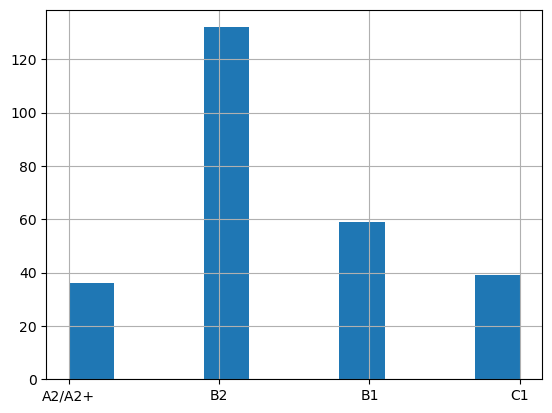

In [61]:
data['rating'].hist()

Распределение по классам неравномерное, это может повлиять на качество обучения, поэтому объединим часть категорий и уберем "переходные категории", сделаем 4 категории "B1","B2","C1" и "A2/A2+"

In [58]:
data['rating'].unique()

array(['A2/A2+', 'B2', 'B1', 'C1', 'B1, B2'], dtype=object)

In [56]:
data.loc[data['rating']=='A2','rating']='A2/A2+'

In [60]:
data.loc[data['rating']=='A2/A2+, B1','rating']='A2/A2+'

In [62]:
data.loc[data['rating']=='B1, B2','rating']='B1'

<AxesSubplot:>

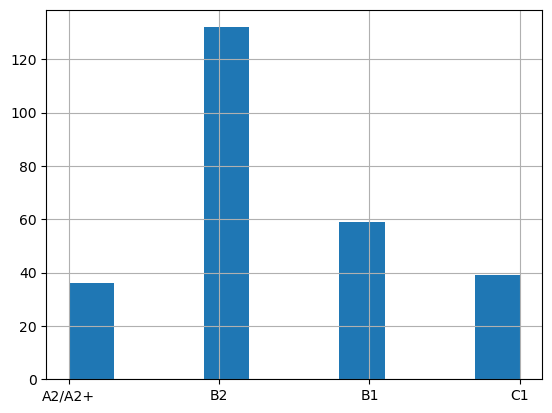

In [64]:
data['rating'].hist()

Стало намного лучше

Данные собраны в датасет и обработаны, теперь можно приступить к обучению моделей

## Обучение модели

Перед обучением модели еше нужно убрать стопслова и все пунктационные знаки

In [79]:
df=data.drop(['title'],axis=1)

In [84]:
df

,subtitles,rating
0,", , within it lies a city. , , outside the bo...",A2/A2+
1,"i got the pyramid in my hand. , , justin, you...",B2
2,", , how can i help you today? , , hi. i can't...",B1
3,"se user zen bud , , once upon a time there was...",B1
4,"com ahmedhamdy , , , , there'll be no strings ...",B2
...,...,...
273,", , i don't know if you can hear me. , , mayb...",A2/A2+
274,", , pots rattling , , any luck? , , how do we...",A2/A2+
275,", , it's not nothing. it's always something. ...",A2/A2+
276,"whoa whoa whoa whoa. , , ma'am. ma'am, please...",A2/A2+


Уберем пунктуацию

In [85]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [87]:
df["subtitles"] = df["subtitles"].apply(lambda text: remove_punctuation(text))

In [88]:
df

,subtitles,rating
0,within it lies a city outside the boundar...,A2/A2+
1,i got the pyramid in my hand justin you get...,B2
2,how can i help you today hi i cant seem t...,B1
3,se user zen bud once upon a time there was a...,B1
4,com ahmedhamdy therell be no strings to bi...,B2
...,...,...
273,i dont know if you can hear me maybe your...,A2/A2+
274,pots rattling any luck how do we tell i...,A2/A2+
275,its not nothing its always something didn...,A2/A2+
276,whoa whoa whoa whoa maam maam please plea...,A2/A2+


Удалим стопслова

In [93]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["subtitles"] = df["subtitles"].apply(lambda text: remove_stopwords(text))
df.head()

,subtitles,rating
0,within lies city outside boundary walls desert...,A2/A2+
1,got pyramid hand justin get back right stop st...,B2
2,help today hi cant seem leave wink someone don...,B1
3,se user zen bud upon time lovely princess ench...,B1
4,com ahmedhamdy therell strings bind hands love...,B2


In [95]:
tfidf = TfidfVectorizer(ngram_range=(1, 3),
                        min_df=2,
                        use_idf=1, smooth_idf=1, sublinear_tf=1)

In [98]:
tfidf.fit(df.subtitles)

TfidfVectorizer(min_df=2, ngram_range=(1, 3), smooth_idf=1, sublinear_tf=1,
                use_idf=1)

In [99]:
train= tfidf.transform(df.subtitles)

In [114]:
def RF(train,data_train):
    features_train, features_valid, target_train, target_valid = train_test_split(train, 
                                                                                  data_train['rating'], test_size=0.25, random_state=12345)
    RF = RandomForestClassifier(random_state=12345, n_estimators=150)
    RF.fit(features_train,target_train)
    predictions=RF.predict(features_valid)
    return(RF,predictions,target_valid)

In [115]:
RF,predictions,target_valid=RF(train,df)

In [116]:
balanced_accuracy_score(target_valid,predictions)

0.38843999138116786

Достаточно хороший результат для начала

In [125]:
def fit_model(train_pool, test_pool, **kwargs):    
    model = CatBoostClassifier(task_type='CPU', iterations = 5000,
                               eval_metric='AUC', od_type='Iter', early_stopping_rounds=500, **kwargs)
    
    return model.fit(train_pool, eval_set=test_pool, 
                     verbose=100, plot=True, 
                     use_best_model=True)  

In [118]:
features_train, features_valid, target_train, target_valid = train_test_split(train, 
                                                                                  df['rating'], test_size=0.25, random_state=12345)

In [121]:
train_pool = Pool(data=features_train, label=target_train)
valid_pool = Pool(data=features_valid, label=target_valid)

In [126]:
model = fit_model(train_pool, valid_pool, learning_rate=0.35,
                  dictionaries = [{
                      'dictionary_id':'Word',
                      'max_dictionary_size': '50000'
                  }],
                 feature_calcers = ['BoW:top_tokens_count=10000'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6420087	best: 0.6420087 (0)	total: 617ms	remaining: 51m 25s
100:	test: 0.9312289	best: 0.9339313 (99)	total: 33.2s	remaining: 26m 49s
200:	test: 0.9272606	best: 0.9347931 (109)	total: 1m 5s	remaining: 26m 2s
300:	test: 0.9303401	best: 0.9347931 (109)	total: 1m 37s	remaining: 25m 24s
400:	test: 0.9318663	best: 0.9347931 (109)	total: 2m 9s	remaining: 24m 50s
500:	test: 0.9318663	best: 0.9347931 (109)	total: 2m 42s	remaining: 24m 16s
600:	test: 0.9318663	best: 0.9347931 (109)	total: 3m 14s	remaining: 23m 46s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.934793148
bestIteration = 109

Shrink model to first 110 iterations.


In [127]:
pre=model.predict( features_valid)

In [128]:
balanced_accuracy_score(target_valid,pre)

0.5683715794009911

Catboost выдает уже неплохое качество

Загрузим модель

In [136]:
torch.save(model,'catboost_film.pth')

# Вывод

Загрузили данные, подготовили их для обучения модели, убрали стоп слова, пунктуацию, HTML тэги и остальную ненужную информацию. Убрали дубликаты, далее провели токенизацию и векторизацию текстовых данных, сначала обучили модель случайного леса, на тестовой выборке она показала результат 0.38( сбалансиорванный accuracy), далее обучили модель catboost, она показала существенно лучше результат в 0.56. Как итоговую модель будем брать именно Catboost